# CNN - Bounding box detection

In [2]:
# !pip install git+https://github.com/fastai/fastai.git

In [58]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from pathlib import Path

from fastai.conv_learner import ConvLearner
from fastai.transforms import RandomRotate, RandomLighting, tfms_from_model, CropType, TfmType
from fastai.dataset import ImageClassifierData
from torchvision.models.resnet import resnet101
from fastai.layers import Flatten
from matplotlib import patches, patheffects
from torch import nn
from torch import optim
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [59]:
PATH = Path('../data')

In [16]:
imgs = []
classes = []
bbs = []

from tqdm import tqdm
import math


for p in tqdm((PATH/'yolo').iterdir()):
    fn = p.parts[-1]

    if fn.endswith('.jpg'):
        imgs.append(fn)
        height, width, channels = plt.imread(p).shape

        labels = open(str(p).replace('.jpg', '.txt')).read().split()
        cls = int(labels[0])
        xmin, ymin, bb_width, bb_height = labels[1:]
        
        bb_width_scaled = float(bb_width) * float(width)
        bb_height_scaled = float(bb_height) * float(height)
        
        # Have to unscale from Yolo format
        x = int(round(float(xmin) * float(width)))
        
        y = int(round(float(ymin) * float(height)))
                
        x2 = int(round(x + bb_width_scaled))
        y2 = int(round(y + bb_height_scaled))
            
        # Dunno why Fast.ai format has to be like this
        bb = f'{y} {x} {y2} {x2}'
        
        bbs.append(bb)
        classes.append(cls)

2350it [00:15, 150.41it/s]


In [17]:
len(bbs)

1175

In [18]:
classes_df = pd.DataFrame({'image': imgs, 'class': classes})[['image', 'class']]
bbs_df = pd.DataFrame({'image': imgs, 'bb': bbs})[['image', 'bb']]

In [19]:
classes_df.to_csv(PATH/'train_classes.csv', index=False, columns=['image', 'class'])
bbs_df.to_csv(PATH/'train_bbs.csv', index=False, columns=['image', 'bb'])

In [20]:
classes_df.head()

,image,class
0,_images_ZO8Npgp4xvw-frame-788.jpg,14
1,5NbYyUlcHU-frame-83.jpg,1
2,pAz_mIjHglw-frame-531.jpg,11
3,pAz_mIjHglw-frame-621.jpg,14
4,pAz_mIjHglw-frame-806.jpg,19


In [21]:
bbs_df.head()

,image,bb
0,_images_ZO8Npgp4xvw-frame-788.jpg,128 369 228 510
1,5NbYyUlcHU-frame-83.jpg,192 557 353 817
2,pAz_mIjHglw-frame-531.jpg,156 161 528 578
3,pAz_mIjHglw-frame-621.jpg,144 279 484 563
4,pAz_mIjHglw-frame-806.jpg,94 176 575 541


In [22]:
augs = [RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [23]:
f_model = resnet101
sz = 224

In [24]:
import fastai

In [25]:
fastai.__file__

'/home/lex/code/auslan-party/ENV/lib/python3.6/site-packages/fastai/__init__.py'

In [26]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs, tfm_y=TfmType.COORD, norm_y=False)
md = ImageClassifierData.from_csv(PATH, 'yolo', PATH/'train_bbs.csv', tfms=tfms, continuous=True, bs=16)

In [29]:
from fastai.core import to_np

In [30]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [31]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [64]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [65]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

[ 27.  44.  89. 140.]
[ 21.  50. 105. 161.]
[ 34.  42.  76. 123.]
[ 34.  42.  76. 123.]
[ 26.   8. 100. 153.]
[ 27.  14.  95. 148.]
[ 34.  42.  76. 123.]
[ 21.  51. 105. 162.]
[ 25.  45.  93. 145.]


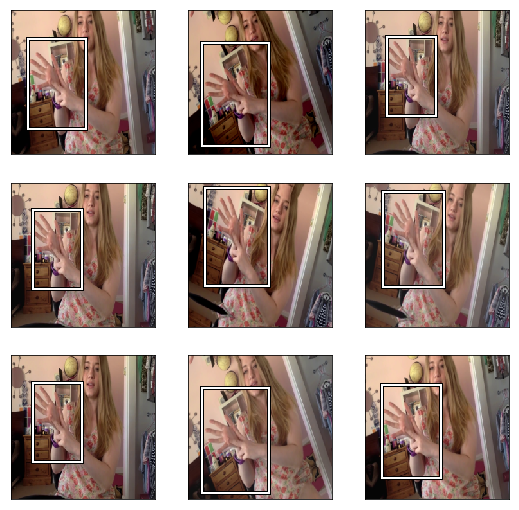

In [34]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]

    b = bb_hw(to_np(y[idx]))
    show_img(ima, ax=ax)
    print(b)
    draw_rect(ax, b)#[128.,  75., 222., 154.])

In [37]:
2048*7*7

100352

In [40]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(100352,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/lex/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [02:38<00:00, 1126137.91it/s]


 71%|███████   | 42/59 [00:05<00:00, 17.74it/s, loss=204] 


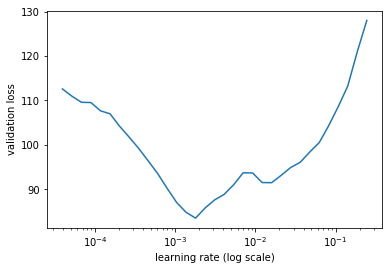

In [41]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [42]:
lr = 0.002

In [43]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      32.582086  13.423985 
    1      18.585499  11.7612                              
    2      11.994236  7.762578                             



[array([7.76258])]

In [44]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      12.792475  9.101788  
    1      13.852755  9.614405                             
    2      9.941295   7.294629                             



[array([7.29463])]

In [46]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss                             
    0      84.525997  3.0842303070348013e+29



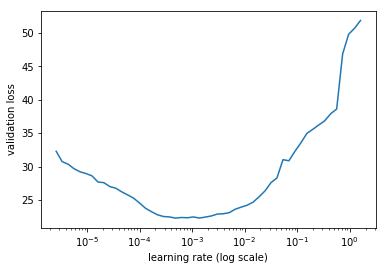

In [47]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [48]:
lr = 0.0005
lrs = np.array([lr/100, lr/10, lr])

In [49]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      14.355611  9.64333   
    1      10.864135  8.586794                             
    2      8.189152   6.590679                             



[array([6.59068])]

In [50]:
learn.freeze_to(-3)

In [51]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                             
    0      9.265743   8.740417  
    1      7.321788   6.269617                             



[array([6.26962])]

## Evaluate

In [52]:
from fastai.core import VV

In [53]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [54]:
preds

array([[ 33.68542,  39.62826, 155.82979, 111.83718],
       [ 47.71293,  98.57509, 213.43745, 193.91405],
       [ 61.41943,  45.49708, 184.48445,  95.65696],
       [ 44.19573,  26.3857 , 153.33342, 108.3451 ],
       [ 61.70862, 132.10286, 121.76866, 164.1534 ],
       [ 76.7707 ,  22.47606, 216.051  , 157.30338],
       [ 21.3513 ,  68.64333, 124.71393, 126.6729 ],
       [ 96.90436,  86.07104, 209.8735 , 162.9402 ],
       [ 64.82109,  65.46865, 225.63754, 182.14041],
       [ 67.88177, 110.38247, 129.1262 , 138.01248],
       [ 51.67524, 103.89928, 217.1081 , 198.48494],
       [ 58.52546, 102.5134 , 219.29292, 170.07584],
       [ 22.23786,  70.29951, 126.00385, 126.53661],
       [105.65709,  16.49695, 221.93924, 150.55644],
       [ 26.03838,  68.4799 , 126.86073, 130.21857],
       [ 26.85174,  59.09627, 118.29909, 128.46841]], dtype=float32)

In [55]:
x.shape

torch.Size([16, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


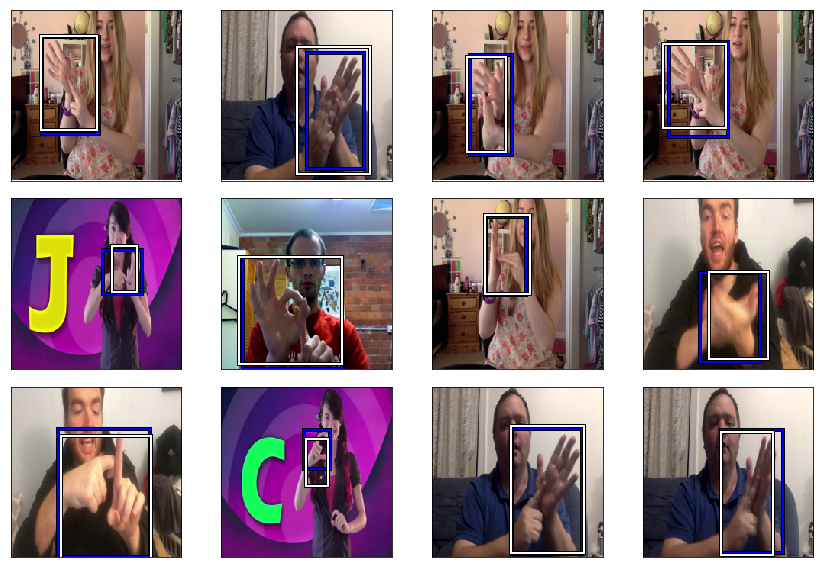

In [69]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima= md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)

    draw_rect(ax, bb_hw(to_np(y[i])), color='blue')
    draw_rect(ax, b)
    

plt.tight_layout()